The notebook automates preprocess of data on any of the 128 UCR time series classification datasets. Download here: http://www.timeseriesclassification.com/index.php, unzip, and set your pwd there to run this notebook as is.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import confusion_matrix

In [3]:
DATAPATH = Path.cwd()/'Adiac'

In [4]:
list(DATAPATH.iterdir())

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Adiac/Adiac_TRAIN'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Adiac/Adiac_TEST')]

In [4]:
def load_df(task):
    filename = f'{task}/{task}_TRAIN.arff'
    print(f'Opening filename: {filename}')
    data = arff.loadarff(DATAPATH/filename)
    df = pd.DataFrame(data[0])
    return df
    
def cleanup(df):
    df.columns = [k for k in range(df.shape[1]-1)]+['target']
    for k in df.columns[:-1]:
        df[k] = df[k].astype('float')
    if df.target.dtype == 'object':
        df['target'] = df['target'].apply(lambda x: x.decode('ascii')).astype('int')
    if sorted(df.target.unique()) != list(np.arange(df.target.nunique())):
        new_targs = pd.DataFrame({'target':df.target.unique()}).reset_index()
        df = pd.merge(df, new_targs, left_on='target', right_on='target').drop('target',axis=1).rename(columns={'index':'target'})
    ts = pd.melt(df.reset_index(), id_vars=['index','target'], var_name='time').rename(columns={'index':'id'})
    ts = ts.groupby(['id','time','target']).value.mean().reset_index()
    return df, ts


def graph_ts(ts):
    "super slow"
    for k in ts.target.unique():
        fig, axes = plt.subplots(figsize=(15,5))
        sns.lineplot(data=ts[ts.target == k], x='time', y='value', units='id', estimator=None, ax=axes)    
    fig, axes = plt.subplots(figsize=(15,5))
    sns.lineplot(data=ts, x='time', hue='target', y='value', units='id', estimator=None, ax=axes)
    return None

In [5]:
task = 'StarLightCurves'
df = load_df(task)
df, ts = cleanup(df)

Opening filename: StarLightCurves/StarLightCurves_TRAIN.arff


(1000, 1025)

/home/tc256760/anaconda3/envs/fastai-master/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


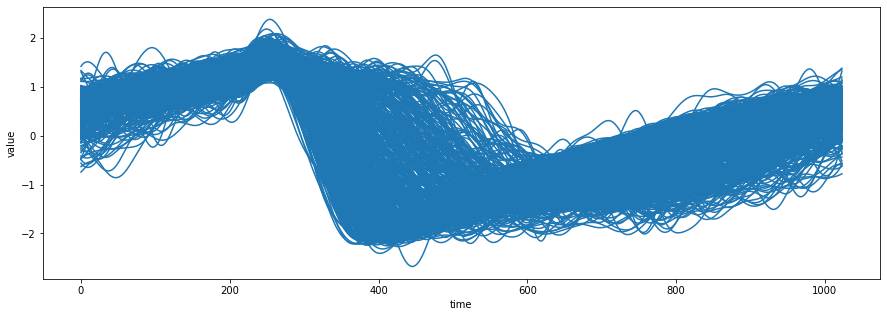

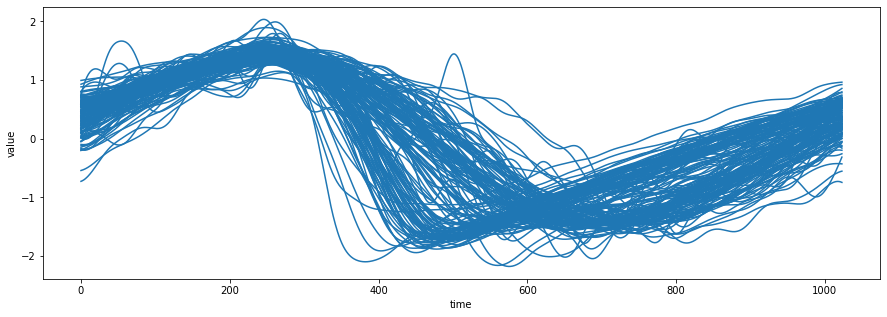

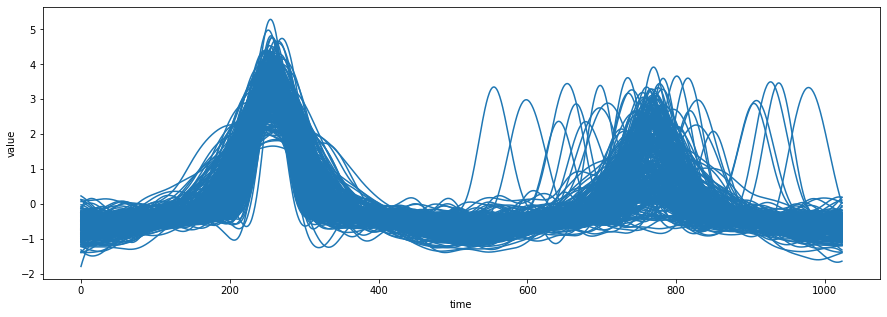

/home/tc256760/anaconda3/envs/fastai-master/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


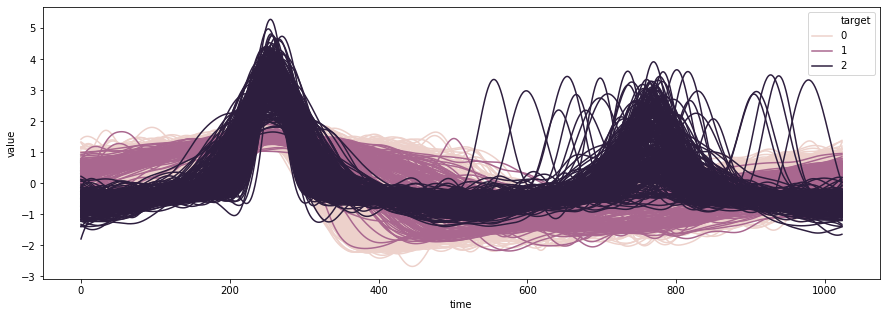

In [6]:
# graph_ts(ts); df.shape

# Torch

In [7]:
import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [8]:
ts.target.nunique()

3

In [9]:
class cls_ds(Dataset):
    def __init__(self, df):
        self.x = torch.stack([torch.Tensor(df.iloc[k][:-1].values.astype('float')) for k in range(df.shape[0])], dim=0)
        self.y = torch.stack([torch.Tensor([df.iloc[k].values[-1].astype('int')]).long() for k in range(df.shape[0])], dim=0)
        self.empty_val = None
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        return self.x[idx,:].unsqueeze(0), self.y[idx].squeeze()

In [10]:
df = df.sample(len(df), replace=False)  #shuffle
num_tr = int(np.floor(df.shape[0] * 0.85))  #split
num_classes = df.target.nunique()

In [11]:
tr_data = cls_ds(df.iloc[:num_tr])
val_data = cls_ds(df.iloc[num_tr:])

In [12]:
tr_data.x.shape

torch.Size([850, 1024])

In [13]:
x,y = tr_data[0]

In [14]:
x.shape, y.shape

(torch.Size([1, 1024]), torch.Size([]))

In [15]:
train_dl = DataLoader(tr_data, batch_size=64, shuffle=True)
valid_dl = DataLoader(val_data, batch_size=64, shuffle=True)

In [16]:
db = DataBunch(train_dl, valid_dl)

Testing dims at input/output

In [17]:
tx, ty = next(iter(train_dl))

In [18]:
tx.shape, ty.shape

(torch.Size([64, 1, 1024]), torch.Size([64]))

## Convolutions

In [19]:
from resnet import AdaptiveConcatPool1d, res_block_1d

In [21]:
def create_resnet(ni, nout): 
    "Basic 1D resnet builder, as seen on paper https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7966039&tag=1"
    return nn.Sequential(conv_layer(ni, 64, ks=9, padding=4, is_1d=True),
                         res_block_1d(64), 
                         conv_layer(64, 128, ks=9, padding=4, is_1d=True),
                         res_block_1d(128),
                         conv_layer(128, 128, ks=9, padding=4, is_1d=True),
                         res_block_1d(128), 
                         AdaptiveConcatPool1d(),
                         Flatten(),
                         nn.Sequential(*bn_drop_lin(2*128,nout))
                        )

In [22]:
model = create_resnet(1, 3); model

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MergeLayer()
    )
  )
  (2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  

In [24]:
model(tx).shape

torch.Size([64, 3])

In [25]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[accuracy],
                                       wd=1e-2)

In [26]:
# learn_res.lr_find(); learn_res.recorder.plot()

In [27]:
learn_res.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.684404,0.997523,0.593333,00:00
1,0.499679,0.590316,0.880000,00:00
2,0.397070,0.443870,0.880000,00:00
3,0.338279,0.281767,0.953333,00:00
4,0.287661,0.249330,0.893333,00:00
5,0.240914,0.425091,0.886667,00:00
6,0.205746,0.138321,0.966667,00:00
7,0.182001,0.124620,0.980000,00:00


In [28]:
p, t = learn_res.get_preds()

In [29]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusino Matrix

In [30]:
get_cm(p,t)

array([[89,  0,  0],
       [ 3, 14,  0],
       [ 0,  0, 44]])